In [18]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import logging
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import shap
from IPython.core.interactiveshell import InteractiveShell
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from yellowbrick.classifier import ClassificationReport

InteractiveShell.ast_node_interactivity = "all"
numba_logger = logging.getLogger("numba")
numba_logger.setLevel(logging.WARNING)
warnings.filterwarnings("ignore")

In [2]:
dataset = load_breast_cancer()

df = pd.DataFrame(
    np.c_[dataset["data"], dataset["target"]],
    columns=np.append(dataset["feature_names"], ["target"]),
)
df.shape

(569, 31)

In [3]:
X = df.drop(["target"], axis=1)
X.head()
y = df["target"]
y.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: target, dtype: float64

In [54]:
for x in range(len(X.columns)):
    print(str(x) + ": " + X.columns[x])

0: mean radius
1: mean texture
2: mean perimeter
3: mean area
4: mean smoothness
5: mean compactness
6: mean concavity
7: mean concave points
8: mean symmetry
9: mean fractal dimension
10: radius error
11: texture error
12: perimeter error
13: area error
14: smoothness error
15: compactness error
16: concavity error
17: concave points error
18: symmetry error
19: fractal dimension error
20: worst radius
21: worst texture
22: worst perimeter
23: worst area
24: worst smoothness
25: worst compactness
26: worst concavity
27: worst concave points
28: worst symmetry
29: worst fractal dimension


In [49]:
# min/max normalization
scaler = MinMaxScaler()
X_std = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
pd.concat(
    [X.min(), X.max(), X_std.min(), X_std.max()],
    axis=1,
    keys=["X min", "X max", "X_std min", "X_std max"],
)

,X min,X max,X_std min,X_std max
mean radius,6.981000,28.11000,0.0,1.0
mean texture,9.710000,39.28000,0.0,1.0
mean perimeter,43.790000,188.50000,0.0,1.0
mean area,143.500000,2501.00000,0.0,1.0
mean smoothness,0.052630,0.16340,0.0,1.0
mean compactness,0.019380,0.34540,0.0,1.0
mean concavity,0.000000,0.42680,0.0,1.0
mean concave points,0.000000,0.20120,0.0,1.0
mean symmetry,0.106000,0.30400,0.0,1.0
mean fractal dimension,0.049960,0.09744,0.0,1.0


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_std, y, test_size=0.2, random_state=42
)

# Support Vector Machine model

In [6]:
svc = SVC(probability=True, kernel="poly", random_state=42)
_ = svc.fit(X_train, y_train)
y_predict_svc = svc.predict(X_test)

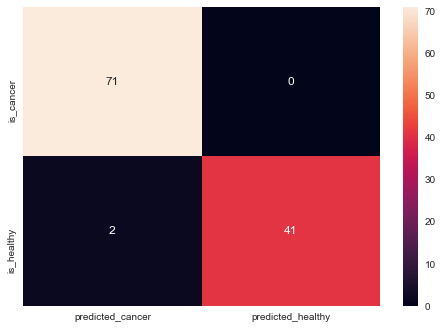

In [7]:
cm = np.array(confusion_matrix(y_test, y_predict_svc, labels=[1, 0]))
confusion = pd.DataFrame(
    cm,
    index=["is_cancer", "is_healthy"],
    columns=["predicted_cancer", "predicted_healthy"],
)
_ = sns.heatmap(confusion, annot=True)

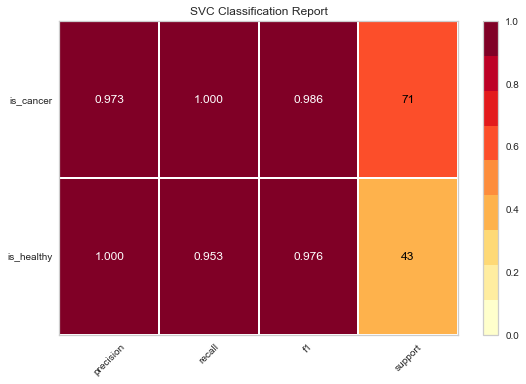

In [8]:
visualizer = ClassificationReport(
    svc, support=True, classes=["is_healthy", "is_cancer"]
)

_ = visualizer.fit(X_train, y_train)
_ = visualizer.score(X_test, y_test)
_ = visualizer.show()

## Determine feature importance

In [9]:
explainer = shap.explainers.Permutation(svc.predict, X_std)
shap_values_svc = explainer(X_std[:100], silent=True)

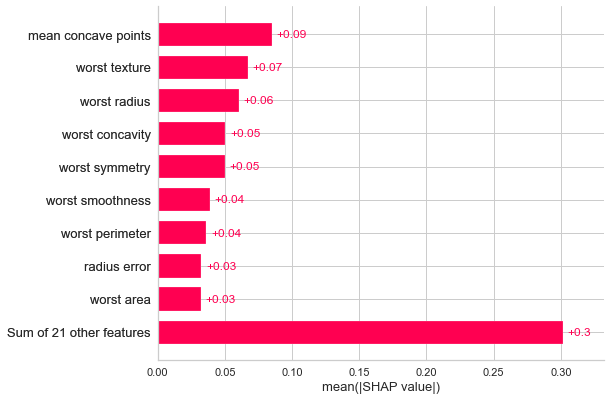

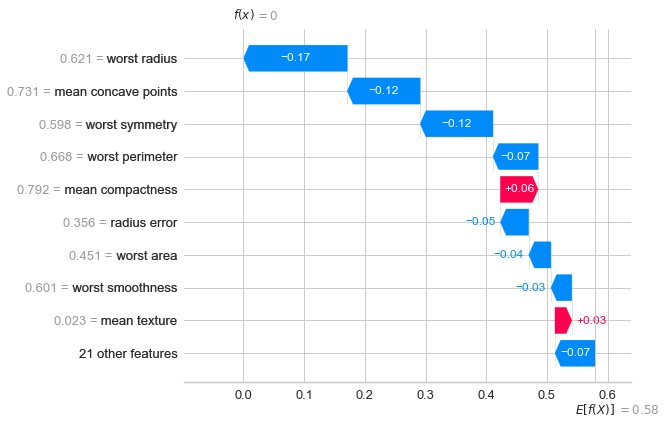

In [10]:
shap.plots.bar(shap_values_svc)
shap.plots.waterfall(shap_values_svc[0])

# Keras neural network model

In [11]:
nn = Sequential()
nn.add(Dense(30, input_shape=(X_train.shape[1],), activation="relu"))
nn.add(Dense(30, activation="relu"))
nn.add(Dropout(0.25))
nn.add(Dense(30, activation="relu"))
nn.add(Dense(1, activation="sigmoid"))

nn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                930       
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 2,821
Trainable params: 2,821
Non-trainable params: 0
_________________________________________________________________


In [12]:
batch_size = 16
epochs = 200

_ = nn.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    verbose=False,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[EarlyStopping(patience=5)],
)

In [13]:
y_predict_nn = np.round(nn.predict(X_test))

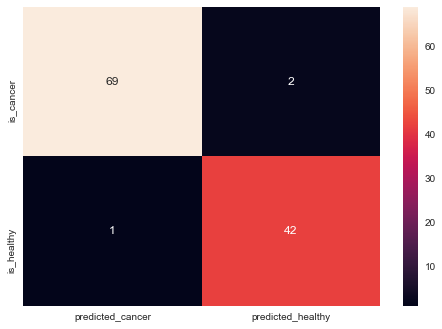

In [14]:
cm = np.array(confusion_matrix(y_test, y_predict_nn, labels=[1, 0]))
confusion = pd.DataFrame(
    cm,
    index=["is_cancer", "is_healthy"],
    columns=["predicted_cancer", "predicted_healthy"],
)
_ = sns.heatmap(confusion, annot=True)

In [15]:
print(classification_report(y_test, y_predict_nn))

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97        43
         1.0       0.99      0.97      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



## Determine feature importance

In [16]:
explainer = shap.explainers.Permutation(nn.predict, X_std)
shap_values_nn = explainer(X_std[:100])

Permutation explainer: 101it [13:29,  8.09s/it]                         


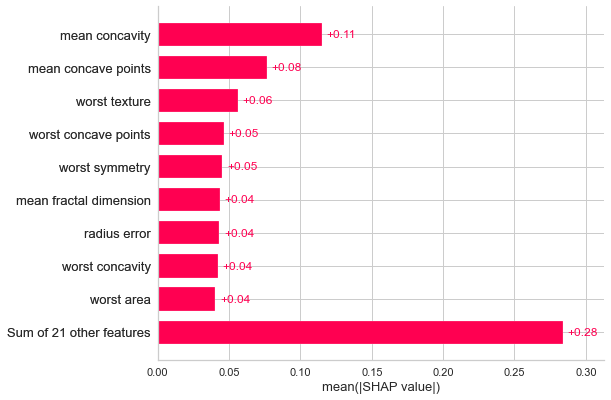

In [17]:
shap.plots.bar(shap_values_nn)

# Random Forest model

In [24]:
rfc = RandomForestClassifier(n_estimators=25, oob_score=True, n_jobs=-1, random_state=42)
_ = rfc.fit(X_train, y_train)
y_predict_rfc = rfc.predict(X_test)

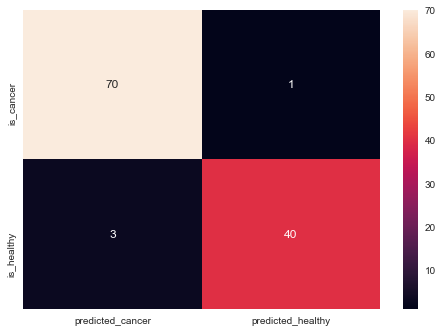

In [25]:
cm = np.array(confusion_matrix(y_test, y_predict_rfc, labels=[1, 0]))
confusion = pd.DataFrame(
    cm,
    index=["is_cancer", "is_healthy"],
    columns=["predicted_cancer", "predicted_healthy"],
)
_ = sns.heatmap(confusion, annot=True)

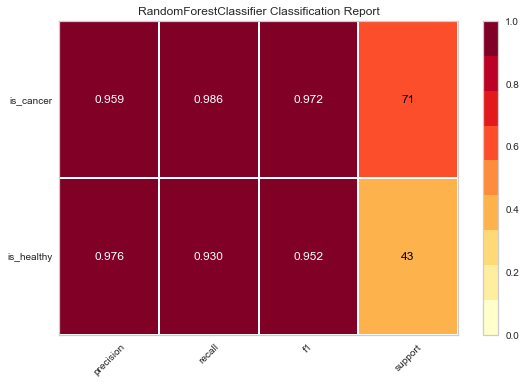

In [26]:
visualizer = ClassificationReport(
    rfc, support=True, classes=["is_healthy", "is_cancer"]
)

_ = visualizer.fit(X_train, y_train)
_ = visualizer.score(X_test, y_test)
_ = visualizer.show()

## Determine feature importance

In [27]:
explainer = shap.explainers.Permutation(rfc.predict, X_std)
shap_values_rfc = explainer(X_std[:100], silent=True)

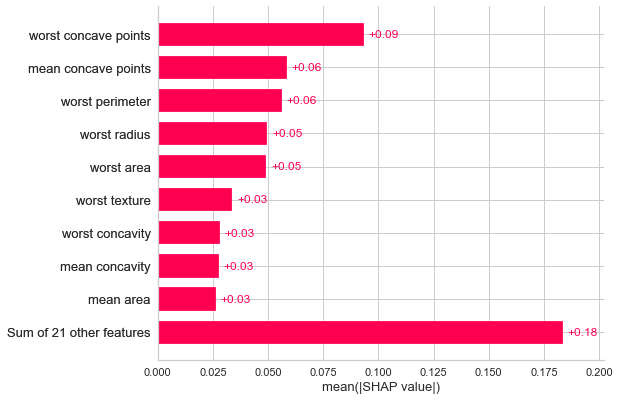

In [55]:
shap.plots.bar(shap_values_rfc)

### Are the most important features for the SVM the same as the NN? Are they the same as we found in the random forest?

| |SVC|Keras|Random Forest|
|-|-----------|-----------|-----------|
|1|**mean concave points**|mean concavity|worst concave points|
|2|worst texture|**mean concave points**|**mean concave points**|
|3|worst radius|worst texture|worst perimeter|
|4|worst concavity|worst concave points|worst radius|
|5|worst symmetry|worst symmetry|worst area|

All 3 models highly value **mean concave points**, but there are a few differences in feature importance among the 3 models. For example, both the NN and RF models highly value **worst concave points**, but is not within the top 10 features for SVC. This indicates that my sensitivty analysis approach is no model-agnostic. The SHAP (SHapley Additive exPlanations) library, uses the Shapley values from game theory to estimate how each feature contributes to the prediction.